In [174]:
import numpy as np

# to use the full dataset
USE_SUBSET = False

def get_subset(x, y):
    if not USE_SUBSET:
        return x, y

    subset_index = 10000
    np.random.seed(1)
    indexes = np.random.permutation(len(x))[:subset_index]
    x, y = x[indexes], y[indexes]

    return x, y

In [175]:
from tensorflow.keras.datasets import mnist
from skimage.color import gray2rgb
from skimage.transform import resize
from sklearn.model_selection import train_test_split

(x_source_train, y_source_train), (x_source_test, y_source_test) = mnist.load_data()

def process_mnist(x):
    x = np.moveaxis(x, 0, -1)
    x = resize(x, (32, 32), anti_aliasing=True, mode='constant')
    x = np.moveaxis(x, -1, 0)
    return gray2rgb(x).astype("float32")

x_source_train = process_mnist(x_source_train)
x_source_test = process_mnist(x_source_test)

x_source_train, y_source_train = get_subset(x_source_train, y_source_train)
#x_source_test, y_source_test = get_subset(x_source_test, y_source_test)

x_source_train, x_source_val, y_source_train, y_source_val = train_test_split(
    x_source_train, y_source_train,
    test_size=int(0.1 * len(x_source_train))
)

x_source_train.shape, x_source_val.shape, x_source_test.shape


((54000, 32, 32, 3), (6000, 32, 32, 3), (10000, 32, 32, 3))

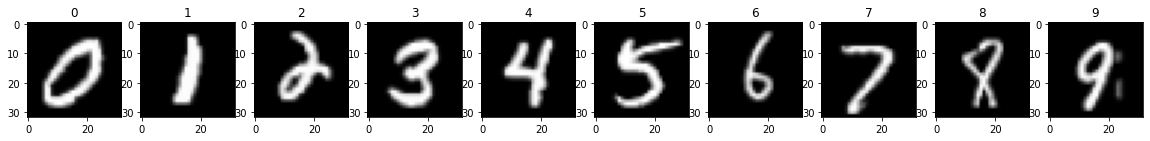

In [3]:
%matplotlib inline
import matplotlib.pyplot as plt

plt.figure(figsize=(20, 15))
for i, digit in enumerate(np.unique(y_source_train), start=1):
    index = np.where(y_source_train == digit)[0][0]
    ax = plt.subplot(1, 10, i)
    ax.imshow(x_source_train[index])
    ax.set_title(digit)


In [4]:
# creating MNIST-M dataset
import tarfile
import os
import cv2
import numpy as np
import skimage
import skimage.io
import urllib.request
import tensorflow as tf
import h5py

URL = 'http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz'
BST_PATH = './Datasets/BSR_bsds500.tgz'
MNIST_M_PATH = './Datasets/MNIST_M/mnistm.h5'

(mnist_train_x, mnist_train_y), (mnist_test_x, mnist_test_y) = tf.keras.datasets.mnist.load_data()

rand = np.random.RandomState(42)

background_data = []



def check_file_or_download():
    if not os.path.isfile(BST_PATH):
        print(f"Download BSDS500 Dataset from {URL}\n [y/(n)]?")
        response = input().lower()
        
        if response == 'y':
            os.makedirs(os.path.dirname(BST_PATH), exist_ok=True)
            urllib.request.urlretrieve(URL, BST_PATH)
        else:
            print(f"Download the BSDS500 Dataset and place at {BST_PATH}")
        
        if os.path.isfile(BST_PATH):
            print(f"BSR Dataset Downloaded at {BST_PATH}")
        else:
            raise FileNotFoundError(f"{BST_PATH} does not exist!")


def process_bsr():
    check_file_or_download()
    
    with tarfile.open(BST_PATH) as f:
        train_files = []
        
        for name in f.getnames():
            if name.startswith('BSR/BSDS500/data/images/train/'):
                train_files.append(name)

        print('Loading BSR training images')

        for name in train_files:
            try:
                fp = f.extractfile(name)
                bg_img = skimage.io.imread(fp)
                background_data.append(bg_img)
            except:
                continue


def compose_image(digit, background):
    """Difference-blend a digit and a random patch from a background image."""
    w, h, _ = background.shape
    dw, dh, _ = digit.shape
    x = np.random.randint(0, w - dw)
    y = np.random.randint(0, h - dh)
    
    bg = background[x:x+dw, y:y+dh]
    return np.abs(bg - digit).astype(np.uint8)


def mnist_to_img(x):
    """Binarize MNIST digit and convert to RGB."""
    x = (x > 0).astype(np.float32)
    d = x.reshape([28, 28, 1]) * 255
    return np.concatenate([d, d, d], 2)


def create_mnistm(X):
    """
    Give an array of MNIST digits, blend random background patches to
    build the MNIST-M dataset as described in
    http://jmlr.org/papers/volume17/15-239/15-239.pdf
    """
    X_ = np.zeros([X.shape[0], 32, 32, 3], np.uint8)
    for i in range(X.shape[0]):
    
        if i % 1000 == 0:
            print(f'Processing {i}/{X.shape[0]}...', end='\r')

        bg_img = rand.choice(background_data)

        d = mnist_to_img(X[i])
        d = compose_image(d, bg_img)
        #print(d.shape)
        res = cv2.resize(np.array(d),(32,32), interpolation = cv2.INTER_AREA)
        X_[i] = res

    return X_



def convert_dict_to_h5dataset(d: dict, f):
    """
    Convert Nested Dictionaries containing Numpy Arrays to HDF5 Dataset
    """
    for item in d.items():
        if isinstance(item[1], dict):
            convert_dict_to_h5dataset(item[1], f.create_group(item[0]))
        else:
            assert(isinstance(item[1], np.ndarray))
            f.create_dataset(item[0], data=item[1])


def write_h5Dataset(dataset_dict, filename):
    
    os.makedirs(os.path.dirname(filename), exist_ok=True)
    with h5py.File(filename, 'w') as f:
        convert_dict_to_h5dataset(dataset_dict, f)
        
        print(f'\n{filename} written')


if __name__ == '__main__':
    process_bsr()
    
    print('Building Training Set...')
    train_x = create_mnistm(mnist_train_x)
    
    print('\nBuilding Testing Set...')
    test_x = create_mnistm(mnist_test_x)
    
    dataset = {
        'train': {
            'X': train_x,
            'Y': mnist_train_y
        },
        'test' : {
            'X' : test_x,
            'Y' : mnist_test_y
        }
    }
    
    write_h5Dataset(dataset, MNIST_M_PATH)

Download BSDS500 Dataset from http://www.eecs.berkeley.edu/Research/Projects/CS/vision/grouping/BSR/BSR_bsds500.tgz
 [y/(n)]?
y
BSR Dataset Downloaded at ./Datasets/BSR_bsds500.tgz
Loading BSR training images
Building Training Set...


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:92: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray



Building Testing Set...

./Datasets/MNIST_M/mnistm.h5 written


In [176]:
#Load MNIST-M [Target]

with h5py.File(MNIST_M_PATH, 'r') as mnist_m:
    mnist_m_train_x, mnist_m_test_x = mnist_m['train']['X'][()], mnist_m['test']['X'][()]


mnist_m_train_x, mnist_m_test_x = mnist_m_train_x / 255.0, mnist_m_test_x / 255.0
mnist_m_train_x, mnist_m_test_x = mnist_m_train_x.astype('float32'), mnist_m_test_x.astype('float32')

mnist_m_train_y, mnist_m_test_y = mnist_train_y, mnist_test_y

# assert(mnist_m_train_x.shape == (60000,32,32,3))
# assert(mnist_m_test_x.shape == (10000,32,32,3))
# assert(mnist_m_train_y.shape == (60000,10))
# assert(mnist_m_test_y.shape == (10000,10))


In [177]:
# import pickle as pkl

# with open("keras_mnistm.pkl", "rb") as f:
#     mnist_m = pkl.load(f)

(x_target_train, y_target_train), (x_target_test, y_target_test) = (mnist_m_train_x, mnist_m_train_y), (mnist_m_test_x, mnist_m_test_y) 


# x_target_train, y_target_train = get_subset(mnist_m["x_train"], mnist_m["y_train"])
# x_target_test, y_target_test = mnist_m["x_test"], mnist_m["y_test"]

# x_target_train = resize(x_target_train, (x_target_train.shape[0], 32, 32, 3), anti_aliasing=True, mode='edge').astype("float32")
# x_target_test = resize(x_target_test, (x_target_test.shape[0], 32, 32, 3), anti_aliasing=True, mode='edge').astype("float32")

x_target_train.shape, x_target_test.shape

((60000, 32, 32, 3), (10000, 32, 32, 3))

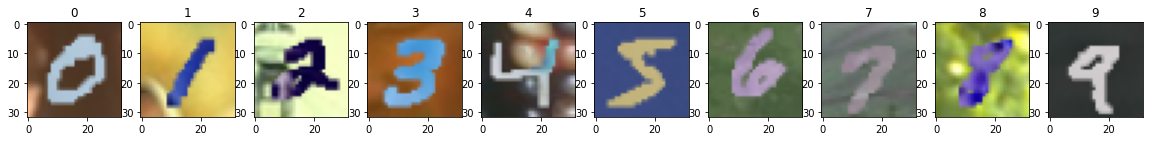

In [178]:
plt.figure(figsize=(20, 15))
for i, digit in enumerate(np.unique(y_target_train), start=1):
    index = np.where(y_target_train == digit)[0][0]
    ax = plt.subplot(1, 10, i)
    ax.imshow(x_target_train[index])
    ax.set_title(digit)


In [179]:
from tensorflow.keras.layers import MaxPool2D, Conv2D, Dense, Dropout, Flatten, Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
import tensorflow as tf


def get_network(input_shape=x_source_train.shape[1:]):
    inputs = Input(shape=input_shape)
    x = Conv2D(32, 5, padding='same', activation='relu', name='conv2d_1')(inputs)
    x = MaxPool2D(pool_size=2, strides=2, name='max_pooling2d_1')(x)
    x = Conv2D(48, 5, padding='same', activation='relu', name='conv2d_2')(x)
    x = MaxPool2D(pool_size=2, strides=2, name='max_pooling2d_2')(x)
    x = Flatten(name='flatten_1')(x)
    x = Dense(100, activation='relu', name='dense_1')(x)
    x = Dense(100, activation='relu', name='dense_2')(x)
    digits_classifier = Dense(10, activation="softmax", name="digits_classifier")(x)
    return Model(inputs=inputs, outputs=digits_classifier)


model = get_network()

model.compile(
    loss="sparse_categorical_crossentropy",
    optimizer=SGD(lr=0.1, momentum=0.9, nesterov=True),
    metrics=['accuracy']
)

model.summary()

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 32, 32, 32)        2432      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 16, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 16, 16, 48)        38448     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 8, 8, 48)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3072)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 100)               3073

In [180]:
history_naive = model.fit(
                            x_source_train, y_source_train,
                            validation_data=(x_source_val, y_source_val),
                            epochs=10,
                            batch_size=128
                        ) 

Epoch 1/10
422/422 [==============================] - 3s 6ms/step - loss: 0.6535 - accuracy: 0.7878 - val_loss: 0.0594 - val_accuracy: 0.9817
Epoch 2/10
422/422 [==============================] - 2s 6ms/step - loss: 0.0532 - accuracy: 0.9839 - val_loss: 0.0677 - val_accuracy: 0.9815
Epoch 3/10
422/422 [==============================] - 2s 6ms/step - loss: 0.0401 - accuracy: 0.9878 - val_loss: 0.0665 - val_accuracy: 0.9835
Epoch 4/10
422/422 [==============================] - 2s 6ms/step - loss: 0.0257 - accuracy: 0.9923 - val_loss: 0.0552 - val_accuracy: 0.9855
Epoch 5/10
422/422 [==============================] - 2s 6ms/step - loss: 0.0237 - accuracy: 0.9931 - val_loss: 0.0606 - val_accuracy: 0.9850
Epoch 6/10
422/422 [==============================] - 2s 6ms/step - loss: 0.0197 - accuracy: 0.9941 - val_loss: 0.0522 - val_accuracy: 0.9863
Epoch 7/10
422/422 [==============================] - 2s 6ms/step - loss: 0.0234 - accuracy: 0.9935 - val_loss: 0.0655 - val_accuracy: 0.9872
Epoch 

In [181]:
print("Loss & Accuracy on MNIST test set:")
model.evaluate(x_source_test, y_source_test, verbose=0)

Loss & Accuracy on MNIST test set:


[0.04560600221157074, 0.989300012588501]

In [182]:
print("Loss & Accuracy on MNIST-M test set:")
model.evaluate(x_target_test, y_target_test, verbose=0)

Loss & Accuracy on MNIST-M test set:


[2.1262130737304688, 0.38350000977516174]

In [183]:
@tf.custom_gradient
def grad_reverse(x):
    y = tf.identity(x)
    def custom_grad(dy):
        return -dy
    return y, custom_grad

class GradReverse(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super().__init__(name="grl")

    def call(self, x):
        return grad_reverse(x)


In [184]:
def get_adaptable_network(input_shape=x_source_train.shape[1:]):
    
    inputs = Input(shape=input_shape)
    x = Conv2D(32, 5, padding='same', activation='relu', name='conv2d_1')(inputs)
    x = MaxPool2D(pool_size=2, strides=2, name='max_pooling2d_1')(x)
    x = Conv2D(48, 5, padding='same', activation='relu', name='conv2d_2')(x)
    x = MaxPool2D(pool_size=2, strides=2, name='max_pooling2d_2')(x)
    features = Flatten(name='flatten_1')(x)
    x = Dense(100, activation='relu', name='dense_digits_1')(features)
    x = Dense(100, activation='relu', name='dense_digits_2')(x)
    digits_classifier = Dense(10, activation="softmax", name="digits_classifier")(x)

    domain_branch = Dense(100, activation="relu", name="dense_domain")(GradReverse()(features))
    domain_classifier = Dense(1, activation="sigmoid", name="domain_classifier")(domain_branch)

    return Model(inputs=inputs, outputs=[digits_classifier, domain_classifier])

model = get_adaptable_network()
model.summary()


Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 32, 32, 3)]  0                                            
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 32, 32, 32)   2432        input_8[0][0]                    
__________________________________________________________________________________________________
max_pooling2d_1 (MaxPooling2D)  (None, 16, 16, 32)   0           conv2d_1[0][0]                   
__________________________________________________________________________________________________
conv2d_2 (Conv2D)               (None, 16, 16, 48)   38448       max_pooling2d_1[0][0]            
____________________________________________________________________________________________

In [185]:
batch_size = 128
epochs = 10

d_source_train = np.ones_like(y_source_train)
d_source_val = np.ones_like(y_source_val)

source_train_generator = tf.data.Dataset.from_tensor_slices(
    (x_source_train, y_source_train, d_source_train)).batch(batch_size)

d_target_train = np.zeros_like(y_target_train)

target_train_generator = tf.data.Dataset.from_tensor_slices(
    (x_target_train, d_target_train)
).batch(batch_size)


In [186]:


from tensorflow.keras.losses import SparseCategoricalCrossentropy, BinaryCrossentropy
from tensorflow.keras.metrics import Mean, Accuracy
import collections

optimizer = SGD(lr=0.01, momentum=0.9, nesterov=True)

cce = SparseCategoricalCrossentropy()
bce = BinaryCrossentropy()

model.compile(
    optimizer=optimizer,
    loss=[cce, bce],
    metrics=["accuracy", "accuracy"]
)

count_dummy = 0

history_da = {}
history_da['source_digits_loss'] = {}
history_da['source_accuracy'] = {}
history_da['source_domain_loss'] = {}
history_da['target_domain_loss'] = {}

In [187]:



def train_epoch(source_train_generator, target_train_generator):
    global lambda_factor, global_step, history_da, count_dummy

    # Keras provide helpful classes to monitor various metrics:
    epoch_source_digits = tf.keras.metrics.Mean()
    epoch_source_domains = tf.keras.metrics.Mean()
    epoch_target_domains = tf.keras.metrics.Mean()
    epoch_accuracy = tf.keras.metrics.SparseCategoricalAccuracy()

    # Fetch all trainable variables but those used uniquely for the digits classification:
    variables_but_classifier = list(filter(lambda x: "digits" not in x.name, model.trainable_variables))

    loss_record = collections.defaultdict(list)

    for i, data in enumerate(zip(source_train_generator, target_train_generator)):
        source_data, target_data = data
        # Training digits classifier & domain classifier on source:
        x_source, y_source, d_source = source_data

        with tf.GradientTape() as tape:
            digits_prob, domains_probs = model(x_source)
            digits_loss = cce(y_source, digits_prob)
            domains_loss = bce(d_source, domains_probs)
            source_loss = digits_loss + 0.2 * domains_loss

        gradients = tape.gradient(source_loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model.trainable_variables))

        epoch_source_digits(digits_loss)
        epoch_source_domains(domains_loss)
        epoch_accuracy(y_source, digits_prob)

        # Training domain classifier on target:
        x_target, d_target = target_data
        with tf.GradientTape() as tape:
            _, domains_probs = model(x_target)
            target_loss = 0.2 * bce(d_target, domains_probs)

        gradients = tape.gradient(target_loss, variables_but_classifier)
        optimizer.apply_gradients(zip(gradients, variables_but_classifier))

        epoch_target_domains(target_loss)

    print("Source digits loss = {}, Source Accuracy = {}, Source domain loss = {}, Target domain loss = {}".format(
        epoch_source_digits.result(), epoch_accuracy.result(),
        epoch_source_domains.result(), epoch_target_domains.result()))
    history_da['source_digits_loss'][count_dummy] = float(epoch_source_digits.result())
    history_da['source_accuracy'][count_dummy] = float(epoch_accuracy.result())
    history_da['source_domain_loss'][count_dummy] = float(epoch_source_domains.result())
    history_da['target_domain_loss'][count_dummy] = float(epoch_target_domains.result())
    count_dummy += 1


for epoch in range(epochs):
    print("Epoch: {}".format(epoch), end=" ")
    loss_record = train_epoch(source_train_generator, target_train_generator)


Epoch: 0 Source digits loss = 0.3129386305809021, Source Accuracy = 0.9048333168029785, Source domain loss = 0.23879392445087433, Target domain loss = 0.08048366755247116
Epoch: 1 Source digits loss = 0.08895637840032578, Source Accuracy = 0.9726481437683105, Source domain loss = 0.49228915572166443, Target domain loss = 0.11716301739215851
Epoch: 2 Source digits loss = 0.06777133047580719, Source Accuracy = 0.9795370101928711, Source domain loss = 0.4251900017261505, Target domain loss = 0.10887004435062408
Epoch: 3 Source digits loss = 0.06563026458024979, Source Accuracy = 0.9799444675445557, Source domain loss = 0.5357134938240051, Target domain loss = 0.11278348416090012
Epoch: 4 Source digits loss = 0.05868212506175041, Source Accuracy = 0.9820926189422607, Source domain loss = 0.5826217532157898, Target domain loss = 0.1163974329829216
Epoch: 5 Source digits loss = 0.05159640312194824, Source Accuracy = 0.9843703508377075, Source domain loss = 0.5635214447975159, Target domain l

In [188]:
# download the model in computer for later use
model.save('DA_MNIST_to_MNIST_m.h5')

In [189]:
from tensorflow import keras
model = keras.models.load_model('DA_MNIST_to_MNIST_m.h5',custom_objects={'GradReverse':GradReverse})

In [190]:
# history_da

In [191]:
import pandas as pd
import json
hist_df = pd.DataFrame(history_da) 
hist_json_file = 'history_da_150e.json' 
with open(hist_json_file, mode='w') as f:
    hist_df.to_json(f)

In [192]:
with open('history_da_150e.json', 'r') as f:
    history_da = json.load(f)
print (len(history_da))

4


In [193]:
for item in history_da:
    print(item)

source_digits_loss
source_accuracy
source_domain_loss
target_domain_loss


In [194]:
source_digits_loss_list = []
source_accuracy_list = []
source_domain_loss_list = []
target_domain_loss_list = []
dummy_count = 0
for sd_l, al, sdom_l, td_list in zip(history_da['source_digits_loss'],  history_da['source_accuracy'], history_da['source_domain_loss'], history_da['target_domain_loss']):
    source_digits_loss_list.append(history_da['source_digits_loss'][str(dummy_count)])
    source_accuracy_list.append(history_da['source_accuracy'][str(dummy_count)])
    source_domain_loss_list.append(history_da['source_domain_loss'][str(dummy_count)])
    target_domain_loss_list.append(history_da['target_domain_loss'][str(dummy_count)])
    dummy_count += 1

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


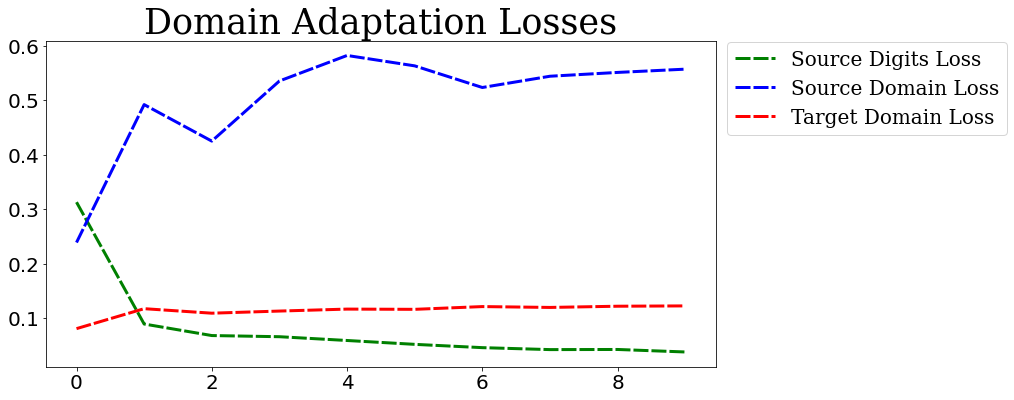

In [195]:
plt.figure(figsize=(12,6))
plt.title('Domain Adaptation Losses', fontsize=35, fontname = 'DejaVu Serif', fontweight = 500)
plt.plot(source_digits_loss_list,color='green', linestyle='--', dashes=(5, 1),  linewidth=3.0)
plt.plot(source_domain_loss_list,color='blue', linestyle='-', dashes=(5, 1),  linewidth=3.0)
plt.plot(target_domain_loss_list,color='red', linestyle='-.', dashes=(5, 1),  linewidth=3.0)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

lgd = plt.legend(['Source Digits Loss', 'Source Domain Loss', 'Target Domain Loss'],loc="lower right",
          prop={'family':'DejaVu Serif', 'size':20}, bbox_to_anchor=(1.45, 0.68))
plt.savefig('da_plot_losses_history.eps',  bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig('da_plot_losses_history.png',  bbox_extra_artists=(lgd,), bbox_inches='tight')

The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.
The PostScript backend does not support transparency; partially transparent artists will be rendered opaque.


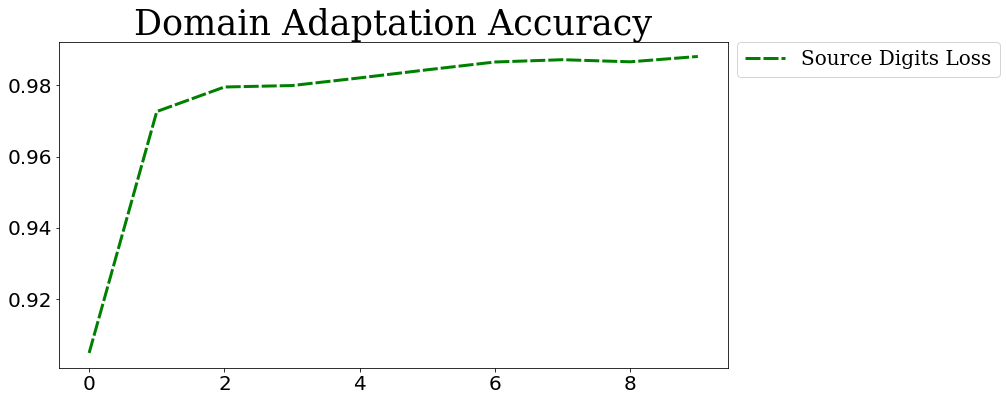

In [196]:
plt.figure(figsize=(12,6))
plt.title('Domain Adaptation Accuracy', fontsize=35, fontname = 'DejaVu Serif', fontweight = 500)
plt.plot(source_accuracy_list,color='green', linestyle='--', dashes=(5, 1),  linewidth=3.0)
# plt.plot(source_domain_loss_list,color='blue', linestyle='-', dashes=(5, 1),  linewidth=3.0)
# plt.plot(target_domain_loss_list,color='red', linestyle='-.', dashes=(5, 1),  linewidth=3.0)

plt.xticks(fontsize=20)
plt.yticks(fontsize=20)

lgd = plt.legend(['Source Digits Loss', 'Source Domain Loss', 'Target Domain Loss'],loc="lower right",
          prop={'family':'DejaVu Serif', 'size':20}, bbox_to_anchor=(1.42, 0.86))
plt.savefig('da_plot_acc_history.eps',  bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig('da_plot_acc_history.png',  bbox_extra_artists=(lgd,), bbox_inches='tight')

In [198]:
from tqdm import tqdm

mnist_pred_list = []
mnist_actual_list = []

for image, y_act in tqdm(zip(x_source_test, y_source_test)):
    mnist_pred_list.append(np.argmax(model.predict(image[np.newaxis,...])[0]))
    mnist_actual_list.append(y_act)

10000it [05:08, 32.46it/s]


In [199]:
print(mnist_pred_list[:10])
print(mnist_actual_list[:10])

[7, 2, 1, 0, 4, 1, 4, 9, 5, 9]
[7, 2, 1, 0, 4, 1, 4, 9, 5, 9]


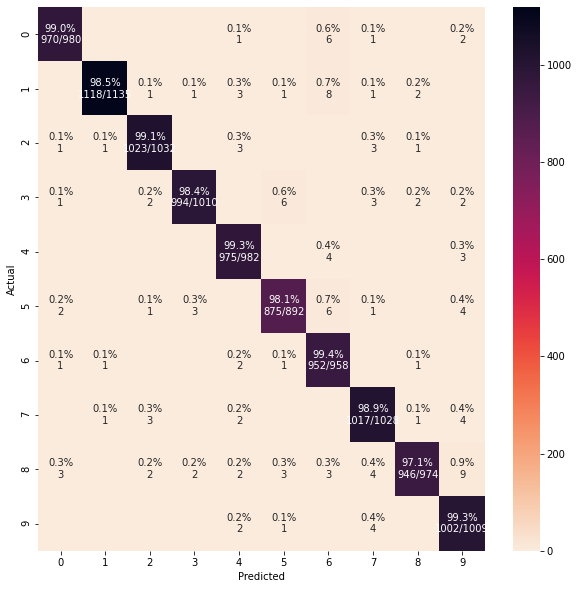

In [200]:
from sklearn.metrics import classification_report, confusion_matrix
matrix = confusion_matrix(mnist_actual_list, mnist_pred_list)
report = classification_report(mnist_actual_list, mnist_pred_list)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix



def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap='rocket_r')
    #plt.savefig(filename)
    plt.savefig('confusion_matrix_mnist_da_100e.png')
    plt.savefig('confusion_matrix_mnist_da_100e.eps')
    plt.show()

cm_analysis(mnist_actual_list, mnist_pred_list, [i for i in range(10)] , ymap=None, figsize=(10,10))


# with open('report_mnist_da_100e.txt', 'w') as f:
#     sys.stdout = f # Change the standard output to the file we created.
#     print(report)
#     #sys.stdout = original_stdout # Reset the standard output to its original value



In [201]:
from tqdm import tqdm

mnist_m_pred_list = []
mnist_m_actual_list = []
print(len(x_target_test))
for image, y_act in tqdm(zip(x_target_test, y_target_test)):
    mnist_m_pred_list.append(np.argmax(model.predict(image[np.newaxis,...])[0]))
    mnist_m_actual_list.append(y_act)

3it [00:00, 29.72it/s]

10000


10000it [05:05, 32.69it/s]


In [202]:
print(mnist_m_pred_list[:10])
print(mnist_m_actual_list[:10])

[7, 2, 1, 6, 4, 2, 4, 9, 6, 9]
[7, 2, 1, 0, 4, 1, 4, 9, 5, 9]


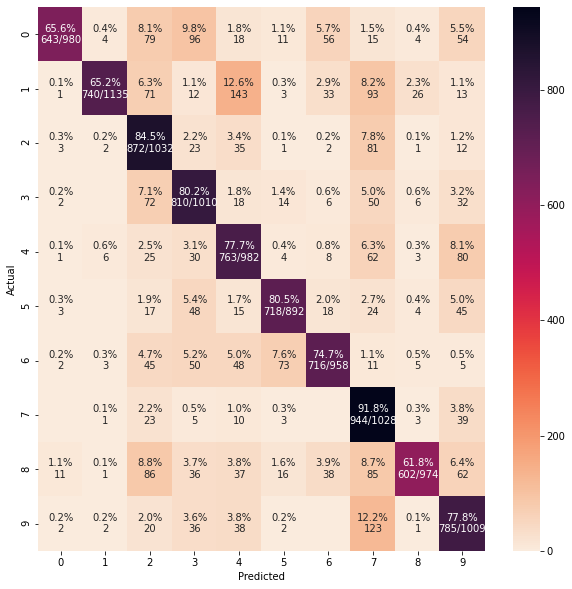

In [203]:
from sklearn.metrics import classification_report, confusion_matrix
matrix = confusion_matrix(mnist_m_actual_list, mnist_m_pred_list)
report = classification_report(mnist_m_actual_list, mnist_m_pred_list)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix



def cm_analysis(y_true, y_pred, labels, ymap=None, figsize=(10,10)):
    """
    Generate matrix plot of confusion matrix with pretty annotations.
    The plot image is saved to disk.
    args: 
      y_true:    true label of the data, with shape (nsamples,)
      y_pred:    prediction of the data, with shape (nsamples,)
      filename:  filename of figure file to save
      labels:    string array, name the order of class labels in the confusion matrix.
                 use `clf.classes_` if using scikit-learn models.
                 with shape (nclass,).
      ymap:      dict: any -> string, length == nclass.
                 if not None, map the labels & ys to more understandable strings.
                 Caution: original y_true, y_pred and labels must align.
      figsize:   the size of the figure plotted.
    """
    if ymap is not None:
        y_pred = [ymap[yi] for yi in y_pred]
        y_true = [ymap[yi] for yi in y_true]
        labels = [ymap[yi] for yi in labels]
    cm = confusion_matrix(y_true, y_pred, labels=labels)
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = '%.1f%%\n%d/%d' % (p, c, s)
            elif c == 0:
                annot[i, j] = ''
            else:
                annot[i, j] = '%.1f%%\n%d' % (p, c)
    cm = pd.DataFrame(cm, index=labels, columns=labels)
    cm.index.name = 'Actual'
    cm.columns.name = 'Predicted'
    fig, ax = plt.subplots(figsize=figsize)
    sns.heatmap(cm, annot=annot, fmt='', ax=ax, cmap='rocket_r')
    #plt.savefig(filename)
    plt.savefig('confusion_matrix_mnist_m_da_100e.png')
    plt.savefig('confusion_matrix_mnist_m_da_100e.eps')
    plt.show()

cm_analysis(mnist_m_actual_list, mnist_m_pred_list, [i for i in range(10)] , ymap=None, figsize=(10,10))


# with open('report_mnist_da_100e.txt', 'w') as f:
#     sys.stdout = f # Change the standard output to the file we created.
#     print(report)
#     #sys.stdout = original_stdout # Reset the standard output to its original value



In [204]:
image_list = x_target_test
pred = np.argmax(model.predict(image[np.newaxis,...])[0])
actual_y = y_target_test

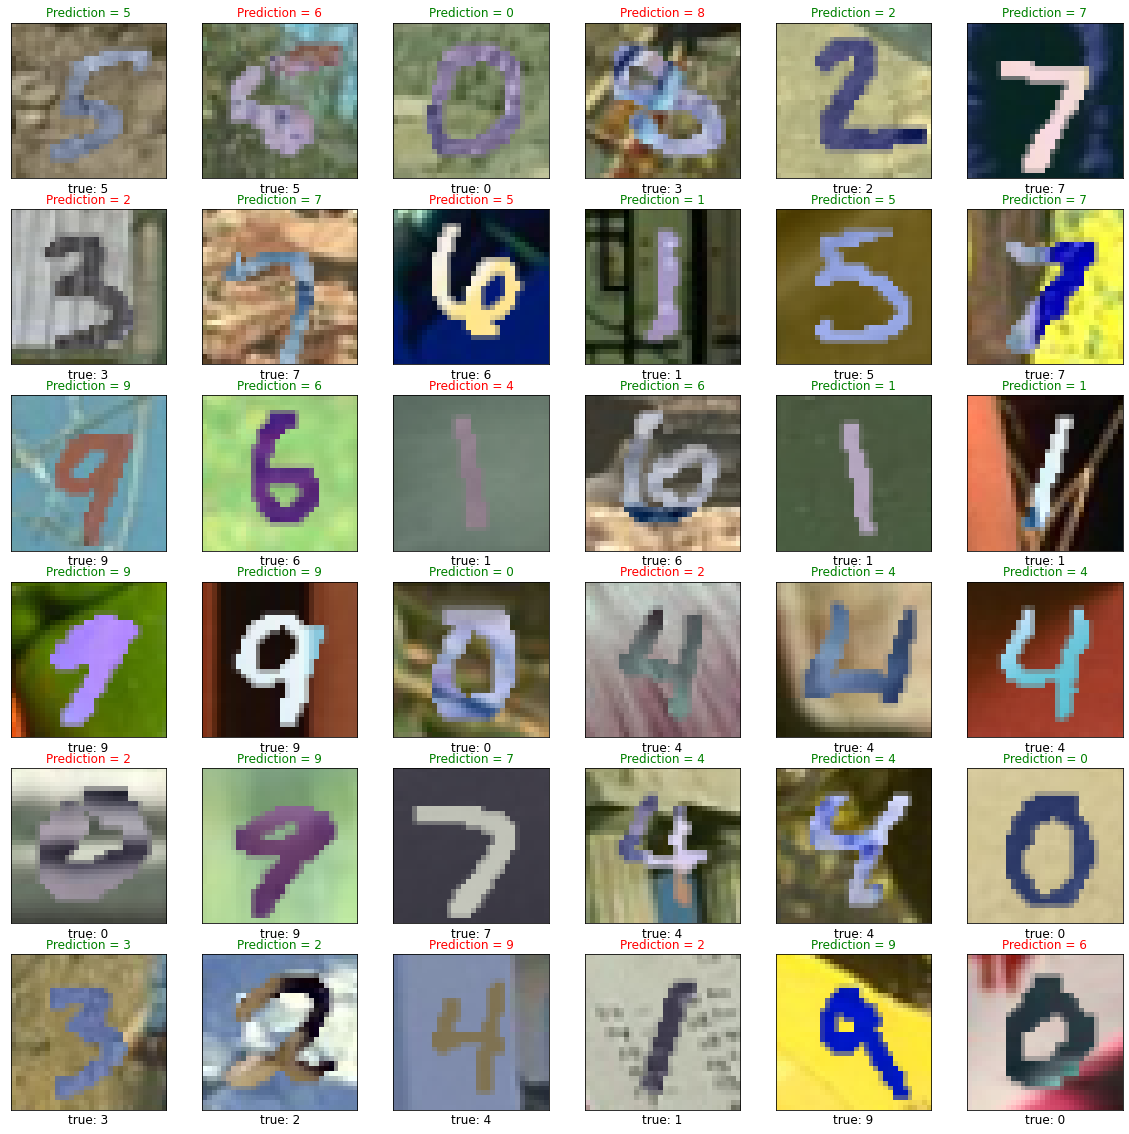

In [213]:
import math
n = 36
random_indices = np.random.permutation(n)
n_cols = 6
n_rows = math.ceil(n / n_cols)
fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 20))
for i, img_idx in enumerate(random_indices):
    ax = axes.flat[i]
    img_ = x_target_test[img_idx].copy()
    ax.imshow(img_)
    actual_pred = ""
    true_val = ""
    actual_pred = np.argmax(model.predict(img_[np.newaxis,...])[0])
    true_val = y_target_test[img_idx]
    if actual_pred == true_val:
        ax.set_title("Prediction = {}".format(actual_pred),fontsize=12).set_color('green')
    else:
        ax.set_title("Prediction = {}".format(actual_pred),fontsize=12).set_color('red')
    ax.set_xlabel('true: {}'.format(true_val),fontsize=12)
    ax.set_xticks([])
    ax.set_yticks([])
plt.savefig('prediction_DA_MNIST_M.png')
plt.savefig('prediction_DA_MNIST_M.eps')

In [19]:
print(model.metrics_names)

['loss', 'digits_classifier_loss', 'domain_classifier_loss']


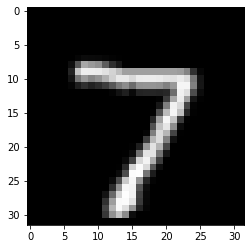

In [24]:
plt.imshow(x_source_test[0])

In [25]:
print(y_source_test[0])

7


In [ ]:
plt.imshow(x_source_test[0])

In [33]:
print(y_source_test)

[7 2 1 ... 4 5 6]


In [32]:
print(y_target_test)

[7 2 1 ... 4 5 6]


In [29]:
np.ones_like(y_source_test)

array([1, 1, 1, ..., 1, 1, 1], dtype=uint8)

In [34]:
print("Loss & Accuracy on MNIST test set:")
model.evaluate(x_source_test, [y_source_test, y_target_test], verbose=1)

Loss & Accuracy on MNIST test set:


TypeError: ignored

In [26]:
print("Loss & Accuracy on MNIST test set:")
model.evaluate(x_source_test, [y_source_test, np.ones_like(y_source_test)], verbose=1)

Loss & Accuracy on MNIST test set:


TypeError: ignored

In [35]:
print("Loss & Accuracy on MNIST-M test set:")
model.evaluate(x_target_test, [y_target_test, np.zeros_like(y_target_test)], verbose=0)

Loss & Accuracy on MNIST-M test set:


TypeError: ignored